In [4]:
# %pip install pandas

import pandas as pd
import numpy as np
from tqdm import tqdm

In [5]:
class Config:
    """
    Configuration class to hold all simulation parameters.
    This makes it easy to adjust the simulation's behavior.
    """
    # General Parameters
    N_HCPS = 30000
    N_WEEKS = 78
    BURN_IN_WEEKS = 12  # Weeks to discard at the start for call history calculation
    
    # HCP Heterogeneity Parameters
    PCT_SPECIALISTS = 0.3
    V_SPECIALIST = np.array([0.1, 0.2, 0.5, 2.0, 4.0, 3.0])
    V_NON_SPECIALIST = np.array([2.0, 3.0, 2.5, 1.0, 0.3, 0.1])
    LOGNORMAL_STD_DEV = 0.5
    
    # Market & Brand Parameters
    N_BRANDS = 5
    MARKET_NBRX_RATES = { # Lambda values for Poisson distribution based on tier
        0: 0 / 12,
        1: 1 / 12,
        2: 3 / 12,
        3: 8 / 12,
        4: 30 / 12,
        5: 65 / 12
    }

    # Call Assignment Parameters
    N_REPS = 150
    CALLS_PER_REP_PER_WEEK = 35
    TOTAL_WEEKLY_CALLS = N_REPS * CALLS_PER_REP_PER_WEEK
    
    # Access probabilities by tier group
    ACCESS_PROB_HIGH_CRITICAL = 0.3 # For tiers 4, 5
    ACCESS_PROB_MEDIUM = 0.7       # For tier 3


In [ ]:
def assign_volume_tiers(n_hcps, config):
    """
    Assigns each HCP a specialty and a volume tier based on the heterogeneous process.
    
    This function implements the core of the HCP heterogeneity:
    1. Assigns specialty (Specialist/Non-Specialist).
    2. Uses specialty-specific weights (v_specialist, v_non_specialist).
    3. Draws an 'alpha' concentration vector from a Log-Normal distribution for each HCP.
    4. Uses 'alpha' to draw a tier probability vector from a Dirichlet distribution.
    5. Assigns the final volume tier based on these unique probabilities.
    
    Returns:
        A DataFrame with HCP IDs, their specialty, and assigned volume tier.
    """
    print("Step 1: Assigning volume tiers to HCPs...")
    
    hcp_ids = np.arange(n_hcps)
    
    # Assign specialty based on the configured percentage
    is_specialist = np.random.binomial(1, config.PCT_SPECIALISTS, n_hcps)
    
    volume_tiers = np.zeros(n_hcps, dtype=int)
    
    for hcp_id in tqdm(range(n_hcps), desc="Generating HCP Tiers"):
        # Select the appropriate weight vector based on specialty
        base_weights = config.V_SPECIALIST if is_specialist[hcp_id] else config.V_NON_SPECIALIST
        
        # Draw concentration parameter 'alpha' from a Log-Normal distribution
        # We use np.log(base_weights) as the mean for the underlying normal distribution
        log_mean = np.log(base_weights)
        alpha = np.random.lognormal(mean=log_mean, sigma=config.LOGNORMAL_STD_DEV, size=len(base_weights))
        
        # Draw tier probabilities from a Dirichlet distribution using the alpha vector
        # This gives a unique probability distribution over tiers for each HCP
        p_tier = np.random.dirichlet(alpha)
        
        # Assign the final volume tier from a categorical distribution
        volume_tiers[hcp_id] = np.random.choice(np.arange(len(p_tier)), p=p_tier)
        
    hcp_df = pd.DataFrame({
        'hcp_id': hcp_ids,
        'is_specialist': is_specialist,
        'volume_tier': volume_tiers
    })
    
    return hcp_df

In [ ]:
def assign_calls(hcp_week_df, hcp_df, config):
    """
    Assigns sales calls to HCPs for each week based on a prioritized tier system.
    
    The logic is executed week by week:
    1. High and Critical tier HCPs are targeted first.
    2. Medium tier HCPs are targeted next with the remaining call budget.
    3. Any leftover calls are randomly distributed to Low and Zero tier HCPs.
    
    Returns:
        The hcp_week_df with an added 'calls' column.
    """
    print("\nStep 3: Assigning weekly calls...")
    
    # Initialize calls column
    hcp_week_df['calls'] = 0
    
    # Get HCP IDs for each tier group
    hcp_tiers = hcp_df.set_index('hcp_id')['volume_tier']
    critical_high_hcp_ids = hcp_df.index[hcp_tiers.isin([4, 5])]
    medium_hcp_ids = hcp_df.index[hcp_tiers.isin([3])]
    low_zero_hcp_ids = hcp_df.index[hcp_tiers.isin([0, 1, 2])]

    for week in tqdm(range(config.N_WEEKS), desc="Assigning Calls Week by Week"):
        
        calls_remaining = config.TOTAL_WEEKLY_CALLS
        
        # --- Tier 4 & 5 (Critical/High) ---
        if len(critical_high_hcp_ids) > 0:
            # Determine which HCPs are successfully accessed this week
            success = np.random.rand(len(critical_high_hcp_ids)) < config.ACCESS_PROB_HIGH_CRITICAL
            successful_ids = critical_high_hcp_ids[success]
            
            # If we have more successful calls than budget, randomly select which ones to keep
            if len(successful_ids) > calls_remaining:
                successful_ids = np.random.choice(successful_ids, size=calls_remaining, replace=False)
            
            # Assign calls and update budget
            week_mask = hcp_week_df['week'] == week
            hcp_mask = hcp_week_df['hcp_id'].isin(successful_ids)
            hcp_week_df.loc[week_mask & hcp_mask, 'calls'] = 1
            calls_remaining -= len(successful_ids)

        # --- Tier 3 (Medium) ---
        if calls_remaining > 0 and len(medium_hcp_ids) > 0:
            success = np.random.rand(len(medium_hcp_ids)) < config.ACCESS_PROB_MEDIUM
            successful_ids = medium_hcp_ids[success]
            
            if len(successful_ids) > calls_remaining:
                successful_ids = np.random.choice(successful_ids, size=calls_remaining, replace=False)
            
            week_mask = hcp_week_df['week'] == week
            hcp_mask = hcp_week_df['hcp_id'].isin(successful_ids)
            hcp_week_df.loc[week_mask & hcp_mask, 'calls'] = 1
            calls_remaining -= len(successful_ids)
            
        # --- Tiers 0, 1, 2 (Low/Zero) ---
        if calls_remaining > 0 and len(low_zero_hcp_ids) > 0:
            # Randomly assign remaining calls to this group
            eligible_hcp_week_indices = hcp_week_df[
                (hcp_week_df['week'] == week) & 
                (hcp_week_df['hcp_id'].isin(low_zero_hcp_ids))
            ].index
            
            if len(eligible_hcp_week_indices) > calls_remaining:
                chosen_indices = np.random.choice(eligible_hcp_week_indices, size=calls_remaining, replace=False)
                hcp_week_df.loc[chosen_indices, 'calls'] = 1
            else: # If fewer HCPs than calls, give one call to each
                hcp_week_df.loc[eligible_hcp_week_indices, 'calls'] = 1

    return hcp_week_df

In [6]:
config = Config()

In [17]:
# config
# hcp_ids = np.arange(config.N_HCPS)
# hcp_ids

In [ ]:
# is_specialist = np.random.binomial(1, config.PCT_SPECIALISTS, config.N_HCPS)
# volume_tiers = np.zeros(config.N_HCPS, dtype=int)

In [16]:
# for hcp_id in tqdm(range(config.N_HCPS), desc="Generating HCP Tiers"):

# base_weights = config.V_SPECIALIST if is_specialist[2] else config.V_NON_SPECIALIST
# print(base_weights)

# log_mean = np.log(base_weights)
# print(log_mean)
# alpha = np.random.lognormal(mean=log_mean, sigma=config.LOGNORMAL_STD_DEV, size=len(base_weights))
# print(alpha)

# p_tier = np.random.dirichlet(alpha)
# print(p_tier)

# volume_tiers[2] = np.random.choice(np.arange(len(p_tier)), p=p_tier)

# volume_tiers[2]  # This will print the assigned volume tier for the third HCP

### Final Simulation Version 2

In [25]:
import pandas as pd
import numpy as np
from tqdm import tqdm

class Config:
    """
    Configuration class to hold all simulation parameters.
    This makes it easy to adjust the simulation's behavior.
    """
    # General Parameters
    N_HCPS = 30000
    N_WEEKS = 78
    BURN_IN_WEEKS = 12  # Weeks to discard at the start for call history calculation
    
    # HCP Heterogeneity Parameters
    PCT_SPECIALISTS = 0.3
    V_SPECIALIST = np.array([0.1, 0.2, 0.5, 2.0, 4.0, 3.0])
    V_NON_SPECIALIST = np.array([2.0, 3.0, 2.5, 1.0, 0.3, 0.1])
    LOGNORMAL_STD_DEV = 0.5
    
    # Market & Brand Parameters
    N_BRANDS = 5
    MARKET_NBRX_RATES = { # Lambda values for Poisson distribution based on tier
        0: 0 / 12,
        1: 1 / 12,
        2: 3 / 12,
        3: 8 / 12,
        4: 30 / 12,
        5: 65 / 12
    }

    # Call Assignment Parameters
    N_REPS = 150
    CALLS_PER_REP_PER_WEEK = 35
    TOTAL_WEEKLY_CALLS = N_REPS * CALLS_PER_REP_PER_WEEK
    
    # Access probabilities by tier group
    ACCESS_PROB_HIGH_CRITICAL = 0.3 # For tiers 4, 5
    ACCESS_PROB_MEDIUM = 0.7       # For tier 3


def assign_volume_tiers(n_hcps, config, rng):
    """
    Assigns each HCP a specialty and a volume tier based on the heterogeneous process.
    
    Args:
        n_hcps (int): Number of HCPs to simulate.
        config (Config): Configuration object.
        rng (np.random.Generator): Random number generator for reproducibility.
        
    Returns:
        A DataFrame with HCP IDs, their specialty, and assigned volume tier.
    """
    print("Step 1: Assigning volume tiers to HCPs...")
    
    hcp_ids = np.arange(n_hcps)
    
    # Assign specialty based on the configured percentage
    is_specialist = rng.binomial(1, config.PCT_SPECIALISTS, n_hcps)
    
    volume_tiers = np.zeros(n_hcps, dtype=int)
    
    for hcp_id in tqdm(range(n_hcps), desc="Generating HCP Tiers"):
        # Select the appropriate weight vector based on specialty
        base_weights = config.V_SPECIALIST if is_specialist[hcp_id] else config.V_NON_SPECIALIST
        
        # Draw concentration parameter 'alpha' from a Log-Normal distribution
        log_mean = np.log(base_weights)
        alpha = rng.lognormal(mean=log_mean, sigma=config.LOGNORMAL_STD_DEV, size=len(base_weights))
        
        # Draw tier probabilities from a Dirichlet distribution
        p_tier = rng.dirichlet(alpha)
        
        # Assign the final volume tier from a categorical distribution
        volume_tiers[hcp_id] = rng.choice(np.arange(len(p_tier)), p=p_tier)
        
    hcp_df = pd.DataFrame({
        'hcp_id': hcp_ids,
        'is_specialist': is_specialist,
        'volume_tier': volume_tiers
    })
    
    return hcp_df


def assign_calls(hcp_week_df, hcp_df, config, rng):
    """
    Assigns sales calls to HCPs for each week based on a prioritized tier system.
    
    Args:
        hcp_week_df (pd.DataFrame): The main weekly data grid.
        hcp_df (pd.DataFrame): HCP profile data.
        config (Config): Configuration object.
        rng (np.random.Generator): Random number generator for reproducibility.

    Returns:
        The hcp_week_df with an added 'calls' column.
    """
    print("\nStep 3: Assigning weekly calls...")
    
    hcp_week_df['calls'] = 0
    
    hcp_tiers = hcp_df.set_index('hcp_id')['volume_tier']
    critical_high_hcp_ids = hcp_df.index[hcp_tiers.isin([4, 5])]
    medium_hcp_ids = hcp_df.index[hcp_tiers.isin([3])]
    low_zero_hcp_ids = hcp_df.index[hcp_tiers.isin([0, 1, 2])]

    for week in tqdm(range(config.N_WEEKS), desc="Assigning Calls Week by Week"):
        
        calls_remaining = config.TOTAL_WEEKLY_CALLS
        
        # --- Tier 4 & 5 (Critical/High) ---
        if len(critical_high_hcp_ids) > 0:
            success = rng.random(len(critical_high_hcp_ids)) < config.ACCESS_PROB_HIGH_CRITICAL
            successful_ids = critical_high_hcp_ids[success]
            
            if len(successful_ids) > calls_remaining:
                successful_ids = rng.choice(successful_ids, size=calls_remaining, replace=False)
            
            week_mask = hcp_week_df['week'] == week
            hcp_mask = hcp_week_df['hcp_id'].isin(successful_ids)
            hcp_week_df.loc[week_mask & hcp_mask, 'calls'] = 1
            calls_remaining -= len(successful_ids)

        # --- Tier 3 (Medium) ---
        if calls_remaining > 0 and len(medium_hcp_ids) > 0:
            success = rng.random(len(medium_hcp_ids)) < config.ACCESS_PROB_MEDIUM
            successful_ids = medium_hcp_ids[success]
            
            if len(successful_ids) > calls_remaining:
                successful_ids = rng.choice(successful_ids, size=calls_remaining, replace=False)
            
            week_mask = hcp_week_df['week'] == week
            hcp_mask = hcp_week_df['hcp_id'].isin(successful_ids)
            hcp_week_df.loc[week_mask & hcp_mask, 'calls'] = 1
            calls_remaining -= len(successful_ids)
            
        # --- Tiers 0, 1, 2 (Low/Zero) ---
        if calls_remaining > 0 and len(low_zero_hcp_ids) > 0:
            eligible_hcp_week_indices = hcp_week_df[
                (hcp_week_df['week'] == week) & 
                (hcp_week_df['hcp_id'].isin(low_zero_hcp_ids))
            ].index
            
            if len(eligible_hcp_week_indices) > calls_remaining:
                chosen_indices = rng.choice(eligible_hcp_week_indices, size=calls_remaining, replace=False)
                hcp_week_df.loc[chosen_indices, 'calls'] = 1
            else:
                hcp_week_df.loc[eligible_hcp_week_indices, 'calls'] = 1

    return hcp_week_df


def generate_hcp_response_parameters(hcp_df, config, rng):
    """
    Generates and attaches tier-specific lift parameters to each HCP.
    
    Args:
        hcp_df (pd.DataFrame): HCP profile data.
        config (Config): Configuration object.
        rng (np.random.Generator): Random number generator for reproducibility.

    Returns:
        A DataFrame with original HCP info plus new response parameter columns.
    """
    print("\nStep 4a: Generating HCP response parameters...")
    hcp_params = hcp_df.copy()
    
    tier = hcp_params['volume_tier']
    beta_base = 1 / (4 + tier)
    hcp_params['beta_tier'] = beta_base + (1 - beta_base) * rng.beta(
        a=8 / (1 + tier), 
        b=2 * (1 + tier)
    )
    
    a_params = np.zeros((len(hcp_params), 3))
    for i, t in enumerate(tier):
        dirichlet_params = np.array([1, 5, 10]) / (1 + t)
        a_params[i, :] = rng.dirichlet(dirichlet_params)
        
    hcp_params['a3_tier'] = a_params[:, 0]
    hcp_params['a2_tier'] = a_params[:, 1]
    hcp_params['a1_tier'] = a_params[:, 2]
    
    return hcp_params


def calculate_weekly_brand_data(hcp_week_df, config, rng):
    """
    Calculates lagged calls, SOM, and simulates Brand NBRx for each HCP-week.
    
    Args:
        hcp_week_df (pd.DataFrame): The main weekly data grid with response params.
        config (Config): Configuration object.
        rng (np.random.Generator): Random number generator for reproducibility.

    Returns:
        The final DataFrame with all simulated data columns.
    """
    print("\nStep 4b: Calculating weekly SOM and Brand NBRx...")
    
    print("  - Calculating lagged calls...")
    hcp_week_df = hcp_week_df.sort_values(['hcp_id', 'week']).set_index(['hcp_id', 'week'])
    
    calls_4w_sum = hcp_week_df.groupby('hcp_id')['calls'].rolling(window=4, min_periods=0).sum().reset_index(0, drop=True)
    
    hcp_week_df['calls_1'] = calls_4w_sum.groupby('hcp_id').shift(1).fillna(0)
    hcp_week_df['calls_2'] = calls_4w_sum.groupby('hcp_id').shift(5).fillna(0)
    hcp_week_df['calls_3'] = calls_4w_sum.groupby('hcp_id').shift(9).fillna(0)
    
    hcp_week_df.reset_index(inplace=True)

    print("  - Calculating lift and SOM...")
    exponent_term = (
        hcp_week_df['a1_tier'] * (hcp_week_df['calls_1'] ** hcp_week_df['beta_tier']) +
        hcp_week_df['a2_tier'] * (hcp_week_df['calls_2'] ** hcp_week_df['beta_tier']) +
        hcp_week_df['a3_tier'] * (hcp_week_df['calls_3'] ** hcp_week_df['beta_tier'])
    )
    lift = (1 - 1/config.N_BRANDS) * (1 - np.exp(-exponent_term))
    hcp_week_df['som'] = (1 / config.N_BRANDS) + lift
    
    print("  - Simulating final brand prescriptions...")
    market_nbrx_int = hcp_week_df['market_nbrx'].astype(int)
    hcp_week_df['brand_nbrx'] = rng.binomial(
        n=market_nbrx_int,
        p=hcp_week_df['som']
    )
    
    return hcp_week_df


def run_simulation_v2(seed=42):
    """
    Main function to orchestrate the entire Version 2 simulation.
    
    Args:
        seed (int): The seed for the random number generator to ensure reproducibility.
    """
    config = Config()
    # Create a random number generator with the specified seed
    rng = np.random.default_rng(seed)
    
    # 1. Create the base HCP profiles
    hcp_df = assign_volume_tiers(config.N_HCPS, config, rng)
    
    # 2. Generate HCP-specific response parameters
    hcp_df_with_params = generate_hcp_response_parameters(hcp_df, config, rng)
    
    # 3. Create grid, merge profiles, and simulate Market NBRx
    print("\nStep 2: Simulating weekly market NBRx...")
    hcp_week_grid = np.mgrid[0:config.N_HCPS, 0:config.N_WEEKS].reshape(2, -1).T
    hcp_week_df = pd.DataFrame(hcp_week_grid, columns=['hcp_id', 'week'])
    hcp_week_df = pd.merge(hcp_week_df, hcp_df_with_params, on='hcp_id', how='left')
    
    lambda_rates = hcp_week_df['volume_tier'].map(config.MARKET_NBRX_RATES)
    hcp_week_df['market_nbrx'] = rng.poisson(lambda_rates)
    
    # 4. Assign weekly calls to HCPs
    hcp_week_df = assign_calls(hcp_week_df, hcp_df_with_params, config, rng)
    
    # 5. Calculate SOM and simulate Brand NBRx
    final_df = calculate_weekly_brand_data(hcp_week_df, config, rng)
    
    # 6. Final cleanup
    print("\nFinalizing data...")
    final_df = final_df[final_df['week'] >= config.BURN_IN_WEEKS].copy()
    
    output_columns = [
        'hcp_id', 'week', 'is_specialist', 'volume_tier',
        'market_nbrx', 'calls', 'brand_nbrx', 'som'
    ]
    final_df = final_df[output_columns]
    
    print(f"\nSimulation complete. Generated {len(final_df)} rows of data.")
    
    return final_df

if __name__ == '__main__':
    # Run the simulation with a fixed seed for reproducibility
    simulated_data = run_simulation_v2(seed=42)
    
    print("\n--- Sample of Final Simulated Data (with seed=42) ---")
    print(simulated_data.head(10))
    
    print("\n--- Summary Statistics ---")
    print(simulated_data[['market_nbrx', 'calls', 'brand_nbrx', 'som']].describe())
    
    print("\n--- Call Distribution by Tier ---")
    print(simulated_data.groupby('volume_tier')['calls'].sum())

    print("\n--- Brand NBRx Distribution by Tier ---")
    print(simulated_data.groupby('volume_tier')['brand_nbrx'].sum())
    # save the final DataFrame to a CSV file
    simulated_data.to_csv('simulated_hcp_dataV2.csv', index=False)

    print("\n--- Simulation completed successfully! ---")



Step 1: Assigning volume tiers to HCPs...


Generating HCP Tiers: 100%|██████████| 30000/30000 [00:01<00:00, 17228.90it/s]



Step 4a: Generating HCP response parameters...

Step 2: Simulating weekly market NBRx...

Step 3: Assigning weekly calls...


Assigning Calls Week by Week: 100%|██████████| 78/78 [00:06<00:00, 11.81it/s]



Step 4b: Calculating weekly SOM and Brand NBRx...
  - Calculating lagged calls...
  - Calculating lift and SOM...
  - Simulating final brand prescriptions...

Finalizing data...

Simulation complete. Generated 1980000 rows of data.

--- Sample of Final Simulated Data (with seed=42) ---
    hcp_id  week  is_specialist  volume_tier  market_nbrx  calls  brand_nbrx  \
12       0    12              1            4            1      0           1   
13       0    13              1            4            3      0           2   
14       0    14              1            4            2      0           0   
15       0    15              1            4            5      1           1   
16       0    16              1            4            2      0           2   
17       0    17              1            4            2      1           2   
18       0    18              1            4            6      0           5   
19       0    19              1            4            2      0        

In [23]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from typing import Dict, Tuple, Optional
import warnings
from dataclasses import dataclass, field
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


@dataclass
class SimulationConfig:
    """
    Configuration class using dataclasses for better type hints and validation.
    """
    # General Parameters
    n_hcps: int = 30000
    n_weeks: int = 78
    burn_in_weeks: int = 12
    random_seed: int = 42
    
    # HCP Heterogeneity Parameters
    pct_specialists: float = 0.3
    v_specialist: np.ndarray = field(default_factory=lambda: np.array([0.1, 0.2, 0.5, 2.0, 4.0, 3.0]))
    v_non_specialist: np.ndarray = field(default_factory=lambda: np.array([2.0, 3.0, 2.5, 1.0, 0.3, 0.1]))
    lognormal_std_dev: float = 0.5
    
    # Market & Brand Parameters
    n_brands: int = 5
    market_nbrx_rates: Dict[int, float] = field(default_factory=lambda: {
        0: 0 / 12, 1: 1 / 12, 2: 3 / 12, 3: 8 / 12, 4: 30 / 12, 5: 65 / 12
    })
    
    # Call Assignment Parameters
    n_reps: int = 150
    calls_per_rep_per_week: int = 35
    access_prob_high_critical: float = 0.3
    access_prob_medium: float = 0.7
    
    @property
    def total_weekly_calls(self) -> int:
        return self.n_reps * self.calls_per_rep_per_week
    
    def __post_init__(self):
        """Validate configuration parameters."""
        if not 0 < self.pct_specialists < 1:
            raise ValueError("pct_specialists must be between 0 and 1")
        if self.n_hcps <= 0 or self.n_weeks <= 0:
            raise ValueError("n_hcps and n_weeks must be positive")
        if self.burn_in_weeks >= self.n_weeks:
            raise ValueError("burn_in_weeks must be less than n_weeks")
        if len(self.v_specialist) != len(self.v_non_specialist):
            raise ValueError("v_specialist and v_non_specialist must have same length")


class HCPTierAssigner:
    """Handles HCP tier assignment logic."""
    
    def __init__(self, config: SimulationConfig):
        self.config = config
        self.rng = np.random.RandomState(config.random_seed)
        
    def assign_volume_tiers(self) -> pd.DataFrame:
        """
        Assigns each HCP a specialty and a volume tier using vectorized operations.
        
        Returns:
            DataFrame with HCP IDs, specialty, and volume tiers.
        """
        logger.info("Assigning volume tiers to HCPs...")
        
        # Generate HCP IDs
        hcp_ids = np.arange(self.config.n_hcps)
        
        # Assign specialty (vectorized)
        is_specialist = self.rng.binomial(1, self.config.pct_specialists, self.config.n_hcps)
        
        # Pre-allocate arrays for better performance
        volume_tiers = np.zeros(self.config.n_hcps, dtype=int)
        n_tiers = len(self.config.v_specialist)
        
        # Vectorized tier assignment for specialists
        specialist_mask = is_specialist == 1
        n_specialists = np.sum(specialist_mask)
        
        if n_specialists > 0:
            volume_tiers[specialist_mask] = self._assign_tiers_vectorized(
                self.config.v_specialist, n_specialists
            )
        
        # Vectorized tier assignment for non-specialists
        non_specialist_mask = ~specialist_mask
        n_non_specialists = np.sum(non_specialist_mask)
        
        if n_non_specialists > 0:
            volume_tiers[non_specialist_mask] = self._assign_tiers_vectorized(
                self.config.v_non_specialist, n_non_specialists
            )
        
        return pd.DataFrame({
            'hcp_id': hcp_ids,
            'is_specialist': is_specialist,
            'volume_tier': volume_tiers
        })
    
    def _assign_tiers_vectorized(self, base_weights: np.ndarray, n_hcps: int) -> np.ndarray:
        """
        Vectorized tier assignment for better performance.
        
        Args:
            base_weights: Base weight vector for the HCP type
            n_hcps: Number of HCPs to assign tiers for
            
        Returns:
            Array of assigned volume tiers
        """
        # Generate alpha parameters for all HCPs at once
        log_mean = np.log(base_weights)
        alpha_matrix = self.rng.lognormal(
            mean=log_mean[np.newaxis, :], 
            sigma=self.config.lognormal_std_dev,
            size=(n_hcps, len(base_weights))
        )
        
        # Generate Dirichlet samples for all HCPs
        # Using gamma distribution property: Dirichlet(α) = Gamma(α_i) / sum(Gamma(α_i))
        gamma_samples = self.rng.gamma(alpha_matrix, 1)
        p_tier_matrix = gamma_samples / gamma_samples.sum(axis=1, keepdims=True)
        
        # Assign tiers using cumulative probabilities
        cumulative_probs = np.cumsum(p_tier_matrix, axis=1)
        random_values = self.rng.random(n_hcps)
        
        # Find the first tier where cumulative probability exceeds random value
        # Fix: Use proper broadcasting for searchsorted
        tiers = np.array([
            np.searchsorted(cumulative_probs[i], random_values[i], side='right')
            for i in range(n_hcps)
        ])
        
        return tiers


class CallAssigner:
    """Handles call assignment logic."""
    
    def __init__(self, config: SimulationConfig):
        self.config = config
        self.rng = np.random.RandomState(config.random_seed + 100)  # Offset seed for different component
        
    def assign_calls(self, hcp_week_df: pd.DataFrame, hcp_df: pd.DataFrame) -> pd.DataFrame:
        """
        Assigns sales calls to HCPs using vectorized operations where possible.
        
        Args:
            hcp_week_df: DataFrame with HCP-week combinations
            hcp_df: DataFrame with HCP information
            
        Returns:
            DataFrame with calls column added
        """
        logger.info("Assigning weekly calls...")
        
        # Initialize calls column
        hcp_week_df = hcp_week_df.copy()
        hcp_week_df['calls'] = 0
        
        # Create tier mapping for faster lookup
        hcp_tiers = hcp_df.set_index('hcp_id')['volume_tier']
        
        # Group HCPs by tier categories
        tier_groups = {
            'critical_high': hcp_df[hcp_tiers.isin([4, 5])]['hcp_id'].values,
            'medium': hcp_df[hcp_tiers.isin([3])]['hcp_id'].values,
            'low_zero': hcp_df[hcp_tiers.isin([0, 1, 2])]['hcp_id'].values
        }
        
        # Process each week
        for week in tqdm(range(self.config.n_weeks), desc="Assigning Calls"):
            calls_remaining = self.config.total_weekly_calls
            week_mask = hcp_week_df['week'] == week
            
            # Process critical/high tier HCPs
            calls_remaining = self._assign_calls_to_tier(
                hcp_week_df, week_mask, tier_groups['critical_high'], 
                calls_remaining, self.config.access_prob_high_critical
            )
            
            # Process medium tier HCPs
            if calls_remaining > 0:
                calls_remaining = self._assign_calls_to_tier(
                    hcp_week_df, week_mask, tier_groups['medium'],
                    calls_remaining, self.config.access_prob_medium
                )
            
            # Process low/zero tier HCPs (no access probability constraint)
            if calls_remaining > 0:
                self._assign_remaining_calls(
                    hcp_week_df, week_mask, tier_groups['low_zero'], calls_remaining
                )
        
        return hcp_week_df
    
    def _assign_calls_to_tier(self, hcp_week_df: pd.DataFrame, week_mask: pd.Series,
                             tier_hcp_ids: np.ndarray, calls_remaining: int, 
                             access_prob: float) -> int:
        """Helper method to assign calls to a specific tier."""
        if len(tier_hcp_ids) == 0:
            return calls_remaining
            
        # Determine successful access
        success_mask = self.rng.rand(len(tier_hcp_ids)) < access_prob
        successful_ids = tier_hcp_ids[success_mask]
        
        # Limit by available calls
        if len(successful_ids) > calls_remaining:
            successful_ids = self.rng.choice(
                successful_ids, size=calls_remaining, replace=False
            )
        
        # Assign calls
        hcp_mask = hcp_week_df['hcp_id'].isin(successful_ids)
        hcp_week_df.loc[week_mask & hcp_mask, 'calls'] = 1
        
        return calls_remaining - len(successful_ids)
    
    def _assign_remaining_calls(self, hcp_week_df: pd.DataFrame, week_mask: pd.Series,
                               tier_hcp_ids: np.ndarray, calls_remaining: int):
        """Helper method to assign remaining calls randomly."""
        if len(tier_hcp_ids) == 0:
            return
            
        eligible_indices = hcp_week_df[week_mask & hcp_week_df['hcp_id'].isin(tier_hcp_ids)].index
        
        if len(eligible_indices) > calls_remaining:
            chosen_indices = self.rng.choice(
                eligible_indices, size=calls_remaining, replace=False
            )
            hcp_week_df.loc[chosen_indices, 'calls'] = 1
        else:
            hcp_week_df.loc[eligible_indices, 'calls'] = 1


class ResponseParameterGenerator:
    """Generates HCP response parameters."""
    
    def __init__(self, config: SimulationConfig):
        self.config = config
        # Fix: Add random state for reproducibility
        self.rng = np.random.RandomState(config.random_seed + 200)
        
    def generate_response_parameters(self, hcp_df: pd.DataFrame) -> pd.DataFrame:
        """
        Generates tier-specific response parameters using vectorized operations.
        
        Args:
            hcp_df: DataFrame with HCP information
            
        Returns:
            DataFrame with response parameters added
        """
        logger.info("Generating HCP response parameters...")
        
        hcp_params = hcp_df.copy()
        tier = hcp_params['volume_tier'].values
        n_hcps = len(hcp_params)
        
        # Vectorized beta parameter generation
        beta_base = 1 / (4 + tier)
        beta_params = self.rng.beta(
            a=8 / (1 + tier),
            b=2 * (1 + tier),
            size=n_hcps
        )
        hcp_params['beta_tier'] = beta_base + (1 - beta_base) * beta_params
        
        # Vectorized a_i parameter generation
        dirichlet_base = np.array([1, 5, 10])
        dirichlet_params = dirichlet_base[np.newaxis, :] / (1 + tier[:, np.newaxis])
        
        # Generate all Dirichlet samples at once
        a_params = np.array([
            self.rng.dirichlet(dirichlet_params[i]) 
            for i in range(n_hcps)
        ])
        
        hcp_params['a3_tier'] = a_params[:, 0]
        hcp_params['a2_tier'] = a_params[:, 1]
        hcp_params['a1_tier'] = a_params[:, 2]
        
        return hcp_params


class MarketDataCalculator:
    """Handles market data calculations and brand NBRx simulation."""
    
    def __init__(self, config: SimulationConfig):
        self.config = config
        # Fix: Add random state for reproducibility
        self.rng = np.random.RandomState(config.random_seed + 300)
        
    def calculate_weekly_brand_data(self, hcp_week_df: pd.DataFrame) -> pd.DataFrame:
        """
        Calculates SOM and simulates Brand NBRx with optimized operations.
        
        Args:
            hcp_week_df: DataFrame with HCP-week data
            
        Returns:
            DataFrame with SOM and Brand NBRx columns added
        """
        logger.info("Calculating weekly SOM and Brand NBRx...")
        
        df = hcp_week_df.copy()
        df = df.sort_values(['hcp_id', 'week'])
        
        # Calculate lagged calls using optimized rolling operations
        logger.info("  - Calculating lagged calls...")
        df = self._calculate_lagged_calls(df)
        
        # Calculate lift and SOM
        logger.info("  - Calculating lift and SOM...")
        df = self._calculate_som(df)
        
        # Simulate Brand NBRx
        logger.info("  - Simulating brand prescriptions...")
        df = self._simulate_brand_nbrx(df)
        
        return df
    
    def _calculate_lagged_calls(self, df: pd.DataFrame) -> pd.DataFrame:
        """Optimized lagged calls calculation."""
        # Reset index to ensure proper alignment
        df_reset = df.reset_index(drop=True)
        
        # Use groupby with rolling for better performance
        grouped = df_reset.groupby('hcp_id')['calls']
        
        # Calculate 4-week rolling sums
        calls_4w_sum = grouped.rolling(window=4, min_periods=0).sum().reset_index(level=0, drop=True)
        
        # Calculate lagged values efficiently with proper index alignment
        calls_1_series = calls_4w_sum.groupby(df_reset['hcp_id']).shift(1).fillna(0)
        calls_2_series = calls_4w_sum.groupby(df_reset['hcp_id']).shift(5).fillna(0)
        calls_3_series = calls_4w_sum.groupby(df_reset['hcp_id']).shift(9).fillna(0)
        
        # Assign values with proper index alignment
        df_reset['calls_1'] = calls_1_series.values
        df_reset['calls_2'] = calls_2_series.values
        df_reset['calls_3'] = calls_3_series.values
        
        # Restore original index structure
        df_reset.index = df.index
        
        return df_reset
    
    def _calculate_som(self, df: pd.DataFrame) -> pd.DataFrame:
        """Vectorized SOM calculation."""
        # Vectorized exponent calculation
        exponent_term = (
            df['a1_tier'] * (df['calls_1'] ** df['beta_tier']) +
            df['a2_tier'] * (df['calls_2'] ** df['beta_tier']) +
            df['a3_tier'] * (df['calls_3'] ** df['beta_tier'])
        )
        
        # Vectorized lift calculation
        lift = (1 - 1/self.config.n_brands) * (1 - np.exp(-exponent_term))
        df['som'] = (1 / self.config.n_brands) + lift
        
        return df
    
    def _simulate_brand_nbrx(self, df: pd.DataFrame) -> pd.DataFrame:
        """Optimized brand NBRx simulation."""
        # Ensure integer values for binomial
        market_nbrx_int = df['market_nbrx'].astype(int)
        som_clipped = np.clip(df['som'], 0, 1)  # Ensure probabilities are valid
        
        # Vectorized binomial sampling using class random state
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', 'invalid value encountered')
            df['brand_nbrx'] = self.rng.binomial(
                n=market_nbrx_int,
                p=som_clipped
            )
        
        return df


class HCPSimulation:
    """Main simulation orchestrator."""
    
    def __init__(self, config: Optional[SimulationConfig] = None):
        self.config = config or SimulationConfig()
        self.tier_assigner = HCPTierAssigner(self.config)
        self.call_assigner = CallAssigner(self.config)
        self.param_generator = ResponseParameterGenerator(self.config)
        self.market_calculator = MarketDataCalculator(self.config)
        # Fix: Add random state for market data generation
        self.rng = np.random.RandomState(self.config.random_seed + 400)
        
    def run_simulation(self) -> pd.DataFrame:
        """
        Runs the complete HCP simulation.
        
        Returns:
            DataFrame with final simulation results
        """
        logger.info("Starting HCP simulation...")
        
        try:
            # Step 1: Generate HCP profiles
            hcp_df = self.tier_assigner.assign_volume_tiers()
            
            # Step 2: Generate response parameters
            hcp_df_with_params = self.param_generator.generate_response_parameters(hcp_df)
            
            # Step 3: Create HCP-week grid and simulate market NBRx
            logger.info("Creating HCP-week grid and simulating market NBRx...")
            hcp_week_df = self._create_hcp_week_grid(hcp_df_with_params)
            
            # Step 4: Assign calls
            hcp_week_df = self.call_assigner.assign_calls(hcp_week_df, hcp_df_with_params)
            
            # Step 5: Calculate SOM and Brand NBRx
            final_df = self.market_calculator.calculate_weekly_brand_data(hcp_week_df)
            
            # Step 6: Final cleanup
            logger.info("Finalizing simulation results...")
            final_df = self._finalize_results(final_df)
            
            logger.info(f"Simulation complete. Generated {len(final_df)} rows of data.")
            return final_df
            
        except Exception as e:
            logger.error(f"Simulation failed: {str(e)}")
            raise
    
    def _create_hcp_week_grid(self, hcp_df: pd.DataFrame) -> pd.DataFrame:
        """Creates the HCP-week grid efficiently."""
        # Create grid using numpy for better performance
        hcp_ids = np.arange(self.config.n_hcps)
        weeks = np.arange(self.config.n_weeks)
        hcp_grid, week_grid = np.meshgrid(hcp_ids, weeks, indexing='ij')
        
        hcp_week_df = pd.DataFrame({
            'hcp_id': hcp_grid.ravel(),
            'week': week_grid.ravel()
        })
        
        # Merge HCP information
        hcp_week_df = pd.merge(hcp_week_df, hcp_df, on='hcp_id', how='left')
        
        # Simulate market NBRx using class random state
        lambda_rates = hcp_week_df['volume_tier'].map(self.config.market_nbrx_rates)
        hcp_week_df['market_nbrx'] = self.rng.poisson(lambda_rates)
        
        return hcp_week_df
    
    def _finalize_results(self, df: pd.DataFrame) -> pd.DataFrame:
        """Cleans up and finalizes the simulation results."""
        # Remove burn-in period
        df = df[df['week'] >= self.config.burn_in_weeks].copy()
        
        # Reset week numbering to start from 0
        df['week'] = df['week'] - self.config.burn_in_weeks
        
        # Select final columns
        output_columns = [
            'hcp_id', 'week', 'is_specialist', 'volume_tier',
            'market_nbrx', 'calls', 'brand_nbrx', 'som'
        ]
        
        return df[output_columns].reset_index(drop=True)


def run_simulation_analysis(df: pd.DataFrame) -> None:
    """Provides summary analysis of simulation results."""
    print("\n" + "="*60)
    print("SIMULATION RESULTS ANALYSIS")
    print("="*60)
    
    print(f"\nDataset Overview:")
    print(f"- Total rows: {len(df):,}")
    print(f"- Unique HCPs: {df['hcp_id'].nunique():,}")
    print(f"- Week range: {df['week'].min()} to {df['week'].max()}")
    print(f"- Specialist ratio: {df['is_specialist'].mean():.1%}")
    
    print(f"\nTier Distribution:")
    tier_dist = df.groupby('volume_tier')['hcp_id'].nunique().sort_index()
    for tier, count in tier_dist.items():
        pct = count / df['hcp_id'].nunique() * 100
        print(f"- Tier {tier}: {count:,} HCPs ({pct:.1f}%)")
    
    print(f"\nCall Statistics:")
    total_calls = df['calls'].sum()
    print(f"- Total calls: {total_calls:,}")
    print(f"- Calls per week (avg): {total_calls / df['week'].nunique():.0f}")
    print(f"- Call rate by tier:")
    call_rates = df.groupby('volume_tier')['calls'].mean().sort_index()
    for tier, rate in call_rates.items():
        print(f"  Tier {tier}: {rate:.1%}")
    
    print(f"\nBrand Performance:")
    print(f"- Avg SOM: {df['som'].mean():.1%}")
    print(f"- Total Brand NBRx: {df['brand_nbrx'].sum():,}")
    print(f"- Avg Brand NBRx per HCP-week: {df['brand_nbrx'].mean():.2f}")
    
    print(f"\nKey Metrics Summary:")
    metrics = df[['market_nbrx', 'calls', 'brand_nbrx', 'som']].describe()
    print(metrics.round(3))


# Example usage and testing
if __name__ == '__main__':
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Create custom configuration if needed
    config = SimulationConfig(
        n_hcps=30000,   # Smaller for testing
        n_weeks=78,    # One year
        burn_in_weeks=12
    )
    
    # Run simulation
    simulator = HCPSimulation(config)
    results = simulator.run_simulation()
    
    # Analyze results
    run_simulation_analysis(results)
    
    # Display sample data
    print(f"\n" + "="*60)
    print("SAMPLE DATA")
    print("="*60)
    print(results.head(10))

2025-07-20 16:33:55,759 - INFO - Starting HCP simulation...
2025-07-20 16:33:55,761 - INFO - Assigning volume tiers to HCPs...
2025-07-20 16:33:55,892 - INFO - Generating HCP response parameters...
2025-07-20 16:33:56,135 - INFO - Creating HCP-week grid and simulating market NBRx...
2025-07-20 16:33:56,543 - INFO - Assigning weekly calls...
Assigning Calls: 100%|██████████| 78/78 [00:06<00:00, 12.39it/s]
2025-07-20 16:34:02,960 - INFO - Calculating weekly SOM and Brand NBRx...
2025-07-20 16:34:03,268 - INFO -   - Calculating lagged calls...
2025-07-20 16:34:05,245 - INFO -   - Calculating lift and SOM...
2025-07-20 16:34:05,435 - INFO -   - Simulating brand prescriptions...
2025-07-20 16:34:05,617 - INFO - Finalizing simulation results...
2025-07-20 16:34:06,254 - INFO - Simulation complete. Generated 1980000 rows of data.



SIMULATION RESULTS ANALYSIS

Dataset Overview:
- Total rows: 1,980,000
- Unique HCPs: 30,000
- Week range: 0 to 65
- Specialist ratio: 29.7%

Tier Distribution:
- Tier 0: 4,796 HCPs (16.0%)
- Tier 1: 7,133 HCPs (23.8%)
- Tier 2: 6,438 HCPs (21.5%)
- Tier 3: 4,260 HCPs (14.2%)
- Tier 4: 4,387 HCPs (14.6%)
- Tier 5: 2,986 HCPs (10.0%)

Call Statistics:
- Total calls: 346,500
- Calls per week (avg): 5250
- Call rate by tier:
  Tier 0: 0.4%
  Tier 1: 0.4%
  Tier 2: 0.3%
  Tier 3: 69.8%
  Tier 4: 30.0%
  Tier 5: 29.9%

Brand Performance:
- Avg SOM: 39.3%
- Total Brand NBRx: 1,292,920
- Avg Brand NBRx per HCP-week: 0.65

Key Metrics Summary:
       market_nbrx        calls   brand_nbrx          som
count  1980000.000  1980000.000  1980000.000  1980000.000
mean         1.073        0.175        0.653        0.393
std          1.959        0.380        1.362        0.255
min          0.000        0.000        0.000        0.200
25%          0.000        0.000        0.000        0.200
50%    

### Final Simulation Version 3

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------- ----------------------- 3.4/8.1 MB 16.7 MB/s eta 0:00:01
   ------------------------------------- -- 7.6/8.1 MB 18.1 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 17.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 18.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   ------------------- -------------------- 3.4/7.0 MB 16.7 MB/s eta 0:00:01
   ---------------------------------------- 7.0/7.0 MB 16.5 MB/s eta 0:00:00

   ---------------------------------------- 0/7 [pyparsing]
   ----- ---------------------------------- 1/7 [pillow]
   ----- ---------------------------------- 1/7 [pillow]
   ----- ---------------------------------- 1/7 [pillow]
   ----- -----------------

The value specified in an AutoRun registry key could not be parsed.


Starting Launch Brand Dynamics Simulation
Creating HCP population...
Simulating weekly HCP activity...


Simulating weeks: 100%|██████████| 77/77 [00:02<00:00, 27.76it/s]


Assigning sales calls...


Assigning calls: 100%|██████████| 78/78 [00:08<00:00,  8.78it/s]


Calculating market share...


C:\Users\rauth\AppData\Local\Temp\ipykernel_14400\3610802926.py:351: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['recent_calls'] = df.groupby('hcp_id', group_keys=False).apply(


Simulating brand prescriptions...

Simulation complete! Generated 2,340,000 rows of data.

Sample of results (first 10 rows):
   hcp_id  week  persona  volume_tier  market_nbrx  calls  baseline_som  \
0       0     0  Learner            2            1      0      0.000106   
1       0     1  Learner            2            1      1      0.000287   
2       0     2  Learner            2            0      0      0.000770   
3       0     3  Learner            2            0      0      0.002031   
4       0     4  Learner            2            0      0      0.005105   
5       0     5  Learner            2            1      0      0.011517   
6       0     6  Learner            2            0      1      0.021412   
7       0     7  Learner            2            0      0      0.031306   
8       0     8  Learner            2            0      0      0.037719   
9       0     9  Learner            2            0      0      0.040792   

        som  brand_nbrx  
0  0.000106           

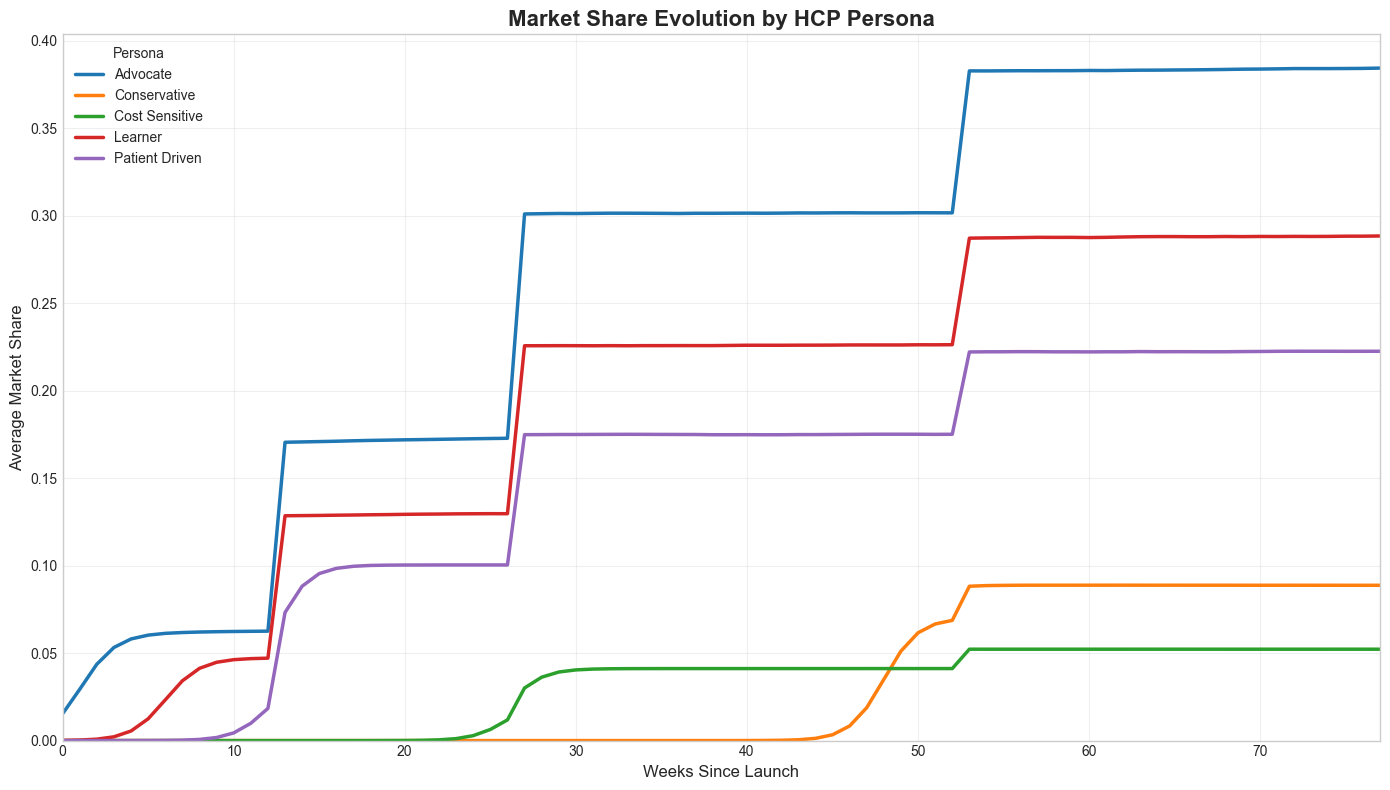

In [ ]:
# %pip install matplotlib
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


class SimulationConfig:
    """
    All configuration parameters for the Launch Brand Dynamics simulation.
    """
    # Basic simulation parameters
    N_HCPS = 30000  # Number of healthcare providers
    N_WEEKS = 78    # Number of weeks to simulate
    
    # How HCPs are distributed across volume tiers at start
    VOLUME_TIER_PROPORTIONS = {
        0: 0.20,  # 25% in tier 0 (lowest volume)
        1: 0.25,  # 30% in tier 1
        2: 0.20,  # 25% in tier 2
        3: 0.20,  # 15% in tier 3
        4: 0.10,  # 5% in tier 4
        5: 0.05   # 0% in tier 5 (highest volume, critical tier)
    }
    
    # How HCP practices change week to week
    PRACTICE_CHANGE_PROBS = {
        'stable': 0.95,   # 95% stay the same
        'growth': 0.025,  # 2.5% grow (move up a tier)
        'decline': 0.025  # 2.5% decline (move down a tier)
    }
    
    # Average prescriptions per week by tier
    MARKET_NBRX_RATES_BY_TIER = {
        0: 0 / 12,    # Tier 0: 0 per year
        1: 1 / 12,    # Tier 1: 1 per year
        2: 3 / 12,    # Tier 2: 3 per year
        3: 8 / 12,    # Tier 3: 8 per year
        4: 30 / 12,   # Tier 4: 30 per year
        5: 65 / 12    # Tier 5: 65 per year
    }
    
    # How much this week's prescriptions depend on last week
    NBRX_CORRELATION = 0.3
    
    # Sales Reps parameters
    N_SALES_REPS = 150
    CALLS_PER_REP_PER_WEEK = 35
    TOTAL_WEEKLY_CALLS = N_SALES_REPS * CALLS_PER_REP_PER_WEEK
    
    # Sales reps use 12-week old data for targeting
    TARGETING_LAG_WEEKS = 12
    
    # Probability of successfully reaching HCP by tier
    ACCESS_PROBS_BY_TIER = {
        0: 1.0,   # Tier 0: Always accessible
        1: 1.0,   # Tier 1: Always accessible
        2: 0.8,   # Tier 2: 80% accessible
        3: 0.6,   # Tier 3: 60% accessible
        4: 0.3,   # Tier 4: 30% accessible
        5: 0.2    # Tier 5: 20% accessible
    }
    
    # HCP personality types and their distribution
    PERSONA_DISTRIBUTION = {
        'Advocate': 0.15,       # 15% are early adopters
        'Learner': 0.25,        # 25% want education first
        'Cost Sensitive': 0.20, # 20% focus on cost
        'Patient Driven': 0.25, # 25% wait for patient demand
        'Conservative': 0.15    # 15% are slow to change
    }
    
    # Market parameters
    N_EXISTING_BRANDS = 4  # Brands already in market
    NEW_BRAND_STRENGTH = 1.5  # Relative strength (1-2 scale)
    
    # How each persona adopts the new brand
    PERSONA_BEHAVIORS = {
        'Advocate': {
            'scaler': 2.0,          # High initial interest
            'adoption_week': 1,     # Adopts immediately
            'magnitude': 1.8,       # Moderate response to calls
            'recency': 18           # Remembers calls for 18 weeks
        },
        'Learner': {
            'scaler': 1.5,          # Good initial interest
            'adoption_week': 6,     # Needs some education
            'magnitude': 1.7,       # Good response to calls
            'recency': 12           # Remembers calls for 12 weeks
        },
        'Cost Sensitive': {
            'scaler': 0.3,          # Low initial interest
            'adoption_week': 26,    # Waits for coverage
            'magnitude': 4.0,       # High response when ready
            'recency': 8            # Short memory
        },
        'Patient Driven': {
            'scaler': 1.2,          # Moderate interest
            'adoption_week': 12,    # Waits for patient demand
            'magnitude': 2.0,       # Good response to calls
            'recency': 8            # Short memory
        },
        'Conservative': {
            'scaler': 0.5,          # Low initial interest
            'adoption_week': 48,    # Very slow to adopt
            'magnitude': 3.0,       # Needs lots of convincing
            'recency': 8            # Short memory
        }
    }
    
    # Insurance coverage rollout schedule
    PAYER_ACCESS_SCHEDULE = [
        (12, 0.10),      # Week 12: 10% coverage
        (26, 0.30),      # Week 26: 30% coverage
        (52, 0.60),      # Week 52: 60% coverage
        (float('inf'), 0.85)  # After week 52: 85% coverage
    ]


def create_hcp_population(config, random_generator):
    """
    Creates the initial HCP population with tiers and personas.
    """
    print("Creating HCP population...")
    
    # Assign volume tiers based on distribution
    tier_choices = list(config.INITIAL_TIER_DISTRIBUTION.keys())
    tier_probabilities = list(config.INITIAL_TIER_DISTRIBUTION.values())
    
    # Fix probabilities to sum to 1 (in case of rounding errors)
    tier_probabilities = np.array(tier_probabilities)
    tier_probabilities = tier_probabilities / tier_probabilities.sum()
    
    initial_tiers = random_generator.choice(
        tier_choices, 
        size=config.N_HCPS, 
        p=tier_probabilities
    )
    
    # Assign personalities
    persona_choices = list(config.PERSONA_DISTRIBUTION.keys())
    persona_probabilities = list(config.PERSONA_DISTRIBUTION.values())
    
    personas = random_generator.choice(
        persona_choices, 
        size=config.N_HCPS, 
        p=persona_probabilities
    )
    
    # Create HCP dataframe
    hcps = pd.DataFrame({
        'hcp_id': range(config.N_HCPS),
        'initial_tier': initial_tiers,
        'persona': personas
    })
    
    # Add persona-specific parameters
    for persona, params in config.PERSONA_BEHAVIORS.items():
        mask = hcps['persona'] == persona
        hcps.loc[mask, 'base_share'] = params['base_share']
        hcps.loc[mask, 'adoption_week'] = params['adoption_week']
        hcps.loc[mask, 'call_impact'] = params['call_impact']
        hcps.loc[mask, 'call_memory'] = params['call_memory']
    
    return hcps


def simulate_weekly_hcp_activity(hcps, config, random_generator):
    """
    Simulates how HCPs change over time (tier transitions and prescriptions).
    """
    print("Simulating weekly HCP activity...")
    
    # Create a row for each HCP for each week
    weeks = range(config.N_WEEKS)
    hcp_ids = range(config.N_HCPS)
    
    # Create all combinations of HCP and week using pandas merge
    weekly_df = pd.merge(
        pd.DataFrame({'hcp_id': hcp_ids}),
        pd.DataFrame({'week': list(weeks)}),
        how='cross'
    )
    
    # Initialize columns
    weekly_df['volume_tier'] = 0
    weekly_df['total_prescriptions'] = 0.0
    
    # Set initial tiers (week 0)
    week_0_mask = weekly_df['week'] == 0
    weekly_df.loc[week_0_mask, 'volume_tier'] = hcps['initial_tier'].values
    
    # Set initial prescriptions based on tier
    tier_to_rx_rate = weekly_df.loc[week_0_mask, 'volume_tier'].map(
        config.PRESCRIPTIONS_PER_WEEK_BY_TIER
    )
    weekly_df.loc[week_0_mask, 'total_prescriptions'] = random_generator.poisson(
        tier_to_rx_rate
    )
    
    # Simulate each week
    for week in tqdm(range(1, config.N_WEEKS), desc="Simulating weeks"):
        # Get previous week's data
        prev_week = weekly_df[weekly_df['week'] == week - 1].copy()
        prev_week = prev_week.set_index('hcp_id')
        
        current_week_mask = weekly_df['week'] == week
        
        # Simulate practice changes
        changes = random_generator.choice(
            ['stable', 'growth', 'decline'],
            size=config.N_HCPS,
            p=list(config.PRACTICE_CHANGE_PROBABILITIES.values())
        )
        
        # Update tiers based on changes
        new_tiers = prev_week['volume_tier'].copy()
        
        # Growth: move up one tier (max tier 5)
        growth_mask = changes == 'growth'
        new_tiers[growth_mask] = np.minimum(new_tiers[growth_mask] + 1, 5)
        
        # Decline: move down one tier (min tier 0)
        decline_mask = changes == 'decline'
        new_tiers[decline_mask] = np.maximum(new_tiers[decline_mask] - 1, 0)
        
        weekly_df.loc[current_week_mask, 'volume_tier'] = new_tiers.values
        
        # Simulate prescriptions with correlation to previous week
        current_tiers = weekly_df.loc[current_week_mask, 'volume_tier']
        rx_rates = current_tiers.map(config.PRESCRIPTIONS_PER_WEEK_BY_TIER)
        
        # New prescriptions
        new_rx = random_generator.poisson(rx_rates)
        
        # Correlated with previous week
        prev_rx = prev_week['total_prescriptions'].values
        corr_factor = config.PRESCRIPTION_CORRELATION
        
        total_rx = (corr_factor * prev_rx + 
                   (1 - corr_factor) * new_rx)
        
        weekly_df.loc[current_week_mask, 'total_prescriptions'] = total_rx
    
    # Round prescriptions to integers
    weekly_df['total_prescriptions'] = weekly_df['total_prescriptions'].round().astype(int)
    
    return weekly_df


def assign_sales_calls(weekly_df, config, random_generator):
    """
    Assigns sales calls to HCPs based on lagged tier information.
    """
    print("Assigning sales calls...")
    
    weekly_df['calls'] = 0
    
    # Create a pivot table for easy tier lookup
    tier_by_week = weekly_df.pivot(
        index='hcp_id', 
        columns='week', 
        values='volume_tier'
    )
    
    for week in tqdm(range(config.N_WEEKS), desc="Assigning calls"):
        calls_remaining = config.TOTAL_WEEKLY_CALLS
        
        # Sales reps use old data for targeting
        data_week = max(0, week - config.TARGETING_LAG_WEEKS)
        perceived_tiers = tier_by_week[data_week]
        
        # Target highest tiers first
        for tier in [5, 4, 3, 2, 1, 0]:
            if calls_remaining <= 0:
                break
            
            # Find HCPs in this tier
            hcps_in_tier = perceived_tiers[perceived_tiers == tier].index
            if len(hcps_in_tier) == 0:
                continue
            
            # Determine who can be reached
            access_prob = config.ACCESS_PROBABILITY_BY_TIER[tier]
            reached = random_generator.random(len(hcps_in_tier)) < access_prob
            accessible_hcps = hcps_in_tier[reached]
            
            # Assign calls (up to remaining capacity)
            n_calls = min(len(accessible_hcps), calls_remaining)
            if n_calls > 0:
                if len(accessible_hcps) > n_calls:
                    called_hcps = random_generator.choice(
                        accessible_hcps, 
                        size=n_calls, 
                        replace=False
                    )
                else:
                    called_hcps = accessible_hcps
                
                # Mark these HCPs as called
                mask = (weekly_df['week'] == week) & \
                       (weekly_df['hcp_id'].isin(called_hcps))
                weekly_df.loc[mask, 'calls'] = 1
                
                calls_remaining -= n_calls
    
    return weekly_df


def calculate_market_share(df, config):
    """
    Calculates how much market share the new brand captures.
    """
    print("Calculating market share...")
    
    # Step 1: Calculate insurance coverage by week
    def get_insurance_coverage(week):
        for week_threshold, coverage in config.PAYER_ACCESS_SCHEDULE:
            if week <= week_threshold:
                return coverage
        return config.PAYER_ACCESS_SCHEDULE[-1][1]
    
    df['insurance_coverage'] = df['week'].apply(get_insurance_coverage)
    
    # Step 2: Calculate adoption curve (S-curve)
    weeks_since_launch = df['week']
    adoption_start_week = df['adoption_week']
    df['adoption_curve'] = 1 / (1 + np.exp(-(weeks_since_launch - adoption_start_week)))
    
    # Step 3: Calculate base market share (before call impact)
    base_share = (
        df['base_share'] * 
        (config.NEW_BRAND_STRENGTH / (config.N_EXISTING_BRANDS + 1)) *
        (1 - np.exp(-df['insurance_coverage'])) *
        df['adoption_curve']
    )
    df['base_market_share'] = np.minimum(base_share, 1.0)
    
    # Step 4: Calculate call impact
    df = df.sort_values(['hcp_id', 'week'])
    
    # Count recent calls for each HCP
    def count_recent_calls(group):
        memory_weeks = int(group['call_memory'].iloc[0])
        return group['calls'].rolling(
            window=memory_weeks, 
            min_periods=0
        ).sum()
    
    # Get calls from previous weeks
    df['recent_calls'] = df.groupby('hcp_id', group_keys=False).apply(
        count_recent_calls
    )
    df['recent_calls'] = df.groupby('hcp_id')['recent_calls'].shift(1).fillna(0)
    
    # Calculate lift from calls
    df['call_lift'] = (
        (df['recent_calls'] ** 0.4) / 
        (4 ** 0.4 + df['recent_calls'] ** 0.6)
    ) ** df['call_impact']
    
    # Step 5: Calculate final market share
    df['final_market_share'] = df['base_market_share'] * (1 + df['call_lift'])
    df['final_market_share'] = np.minimum(df['final_market_share'], 1.0)
    
    return df


def simulate_brand_prescriptions(df, random_generator):
    """
    Simulates actual prescriptions for the new brand.
    """
    print("Simulating brand prescriptions...")
    
    # Use binomial distribution: 
    # n = total prescriptions, p = market share
    df['brand_prescriptions'] = random_generator.binomial(
        n=df['total_prescriptions'],
        p=df['final_market_share']
    )
    
    return df


def run_simulation(seed=42):
    """
    Main function that runs the complete simulation.
    """
    # Set up
    config = SimulationConfig()
    rng = np.random.default_rng(seed)
    
    print("Starting Launch Brand Dynamics Simulation")
    print("=" * 50)
    
    # Step 1: Create HCP population
    hcps = create_hcp_population(config, rng)
    
    # Step 2: Simulate weekly activity
    weekly_data = simulate_weekly_hcp_activity(hcps, config, rng)
    
    # Step 3: Assign sales calls
    weekly_data = assign_sales_calls(weekly_data, config, rng)
    
    # Step 4: Merge HCP info with weekly data
    full_data = pd.merge(weekly_data, hcps, on='hcp_id', how='left')
    
    # Step 5: Calculate market share
    full_data = calculate_market_share(full_data, config)
    
    # Step 6: Simulate prescriptions
    full_data = simulate_brand_prescriptions(full_data, rng)
    
    # Clean up and select final columns
    final_columns = [
        'hcp_id', 'week', 'persona', 'volume_tier',
        'total_prescriptions', 'calls', 'base_market_share', 
        'final_market_share', 'brand_prescriptions'
    ]
    
    # Rename columns to match original
    full_data = full_data.rename(columns={
        'total_prescriptions': 'market_nbrx',
        'base_market_share': 'baseline_som',
        'final_market_share': 'som',
        'brand_prescriptions': 'brand_nbrx'
    })
    
    result = full_data[['hcp_id', 'week', 'persona', 'volume_tier',
                       'market_nbrx', 'calls', 'baseline_som', 'som', 'brand_nbrx']]
    
    print(f"\nSimulation complete! Generated {len(result):,} rows of data.")
    print("=" * 50)
    
    return result


def visualize_results(data):
    """
    Creates a plot showing market share evolution by persona.
    """
    print("\nCreating visualization...")
    
    # Calculate average market share by persona and week
    avg_share_by_persona = data.groupby(['week', 'persona'])['som'].mean()
    avg_share_by_persona = avg_share_by_persona.unstack('persona')
    
    # Create plot
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plot each persona
    for persona in avg_share_by_persona.columns:
        ax.plot(avg_share_by_persona.index, 
               avg_share_by_persona[persona], 
               linewidth=2.5, 
               label=persona)
    
    # Customize plot
    ax.set_title('Market Share Evolution by HCP Persona', 
                fontsize=16, fontweight='bold')
    ax.set_xlabel('Weeks Since Launch', fontsize=12)
    ax.set_ylabel('Average Market Share', fontsize=12)
    ax.legend(title='Persona', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, data['week'].max())
    ax.set_ylim(0)
    
    plt.tight_layout()
    return fig, ax


# Run the simulation
if __name__ == '__main__':
    # Run simulation
    results = run_simulation(seed=42)
    
    # Show sample data
    print("\nSample of results (first 10 rows):")
    print(results.head(10))
    
    # Show summary statistics for last 26 weeks
    print("\nSummary statistics (last 26 weeks):")
    last_26_weeks = results[results['week'] > 52]
    print(last_26_weeks.describe())
    
    # Create visualization
    fig, ax = visualize_results(results)
    plt.show()

## Version 3

In [1]:
class Config:
    """
    All configuration parameters for the Launch Brand Dynamics simulation.
    """
    # Basic simulation parameters
    N_HCPS = 30000  # Number of healthcare providers
    N_WEEKS = 78    # Number of weeks to simulate
    
    # How HCPs are distributed across volume tiers at start
    VOLUME_TIER_PROPORTIONS = {
        0: 0.20,  # 25% in tier 0 (lowest volume)
        1: 0.25,  # 30% in tier 1
        2: 0.20,  # 25% in tier 2
        3: 0.20,  # 15% in tier 3
        4: 0.10,  # 5% in tier 4
        5: 0.05   # 0% in tier 5 (highest volume, critical tier)
    }
    
    # How HCP practices change week to week
    PRACTICE_CHANGE_PROBS = {
        'stable': 0.95,   # 95% stay the same
        'growth': 0.025,  # 2.5% grow (move up a tier)
        'decline': 0.025  # 2.5% decline (move down a tier)
    }
    
    # Average prescriptions per week by tier
    MARKET_NBRX_RATES_BY_TIER = {
        0: 0 / 12,    # Tier 0: 0 per year
        1: 1 / 12,    # Tier 1: 1 per year
        2: 3 / 12,    # Tier 2: 3 per year
        3: 8 / 12,    # Tier 3: 8 per year
        4: 30 / 12,   # Tier 4: 30 per year
        5: 65 / 12    # Tier 5: 65 per year
    }
    
    # How much this week's prescriptions depend on last week
    NBRX_CORRELATION = 0.3
    
    # Sales Reps parameters
    N_SALES_REPS = 150
    CALLS_PER_REP_PER_WEEK = 35
    TOTAL_WEEKLY_CALLS = N_SALES_REPS * CALLS_PER_REP_PER_WEEK
    
    # Sales reps use 12-week old data for targeting
    TARGETING_LAG_WEEKS = 12
    
    # Probability of successfully reaching HCP by tier
    ACCESS_PROBS_BY_TIER = {
        0: 1.0,   # Tier 0: Always accessible
        1: 1.0,   # Tier 1: Always accessible
        2: 0.8,   # Tier 2: 80% accessible
        3: 0.6,   # Tier 3: 60% accessible
        4: 0.3,   # Tier 4: 30% accessible
        5: 0.2    # Tier 5: 20% accessible
    }
    
    # HCP personality types and their distribution
    PERSONA_DISTRIBUTION = {
        'Advocate': 0.15,       # 15% are early adopters
        'Learner': 0.25,        # 25% want education first
        'Cost Sensitive': 0.20, # 20% focus on cost
        'Patient Driven': 0.25, # 25% wait for patient demand
        'Conservative': 0.15    # 15% are slow to change
    }
    
    # Market parameters
    N_EXISTING_BRANDS = 4  # Brands already in market
    NEW_BRAND_STRENGTH = 1.5  # Relative strength (1-2 scale)
    
    # How each persona adopts the new brand
    PERSONA_BEHAVIORS = {
        'Advocate': {
            'scaler': 2.0,          # High initial interest
            'adoption_week': 1,     # Adopts immediately
            'magnitude': 1.8,       # Moderate response to calls
            'recency': 18           # Remembers calls for 18 weeks
        },
        'Learner': {
            'scaler': 1.5,          # Good initial interest
            'adoption_week': 6,     # Needs some education
            'magnitude': 1.7,       # Good response to calls
            'recency': 12           # Remembers calls for 12 weeks
        },
        'Cost Sensitive': {
            'scaler': 0.3,          # Low initial interest
            'adoption_week': 26,    # Waits for coverage
            'magnitude': 4.0,       # High response when ready
            'recency': 8            # Short memory
        },
        'Patient Driven': {
            'scaler': 1.2,          # Moderate interest
            'adoption_week': 12,    # Waits for patient demand
            'magnitude': 2.0,       # Good response to calls
            'recency': 8            # Short memory
        },
        'Conservative': {
            'scaler': 0.5,          # Low initial interest
            'adoption_week': 48,    # Very slow to adopt
            'magnitude': 3.0,       # Needs lots of convincing
            'recency': 8            # Short memory
        }
    }
    
    # Insurance coverage rollout schedule
    PAYER_ACCESS_SCHEDULE = [
        (12, 0.10),      # Week 12: 10% coverage
        (26, 0.30),      # Week 26: 30% coverage
        (52, 0.60),      # Week 52: 60% coverage
        (float('inf'), 0.85)  # After week 52: 85% coverage
    ]

In [ ]:
def create_hcp_population(config, random_gen):
    """
    Creates the initial HCP population with tiers and personas.
    """
    print("Creating HCP population...")
    
    # Assign volume tiers based on distribution
    tier_choices = list(config.VOLUME_TIER_PROPORTIONS.keys())
    tier_probabilities = list(config.VOLUME_TIER_PROPORTIONS.values())
    
    # Fix probabilities to sum to 1 (in case of rounding errors)
    tier_probabilities = np.array(tier_probabilities)
    tier_probabilities = tier_probabilities / tier_probabilities.sum()
    
    initial_tiers = random_gen.choice(
        tier_choices, 
        size=config.N_HCPS, 
        p=tier_probabilities
    )
    
    # Assign personalities
    persona_choices = list(config.PERSONA_DISTRIBUTION.keys())
    persona_probabilities = list(config.PERSONA_DISTRIBUTION.values())
    
    personas = random_gen.choice(
        persona_choices, 
        size=config.N_HCPS, 
        p=persona_probabilities
    )
    
    # Create HCP dataframe
    hcps = pd.DataFrame({
        'hcp_id': range(config.N_HCPS),
        'initial_tier': initial_tiers,
        'persona': personas
    })
    
    # Add persona-specific parameters
    for persona, params in config.PERSONA_BEHAVIORS.items():
        mask = hcps['persona'] == persona
        hcps.loc[mask, 'scaler'] = params['scaler']
        hcps.loc[mask, 'adoption_week'] = params['adoption_week']
        hcps.loc[mask, 'magnitude'] = params['magnitude']
        hcps.loc[mask, 'recency'] = params['recency']
    
    return hcps

In [ ]:
def simulate_weekly_hcp_activity(hcps, config, random_gen):
    """
    Simulates how HCPs change over time (tier transitions and prescriptions).
    """
    print("Simulating weekly HCP activity...")
    
    # Create a row for each HCP for each week
    weeks = range(config.N_WEEKS)
    hcp_ids = range(config.N_HCPS)
    
    # Create all combinations of HCP and week using pandas merge
    weekly_df = pd.merge(
        pd.DataFrame({'hcp_id': hcp_ids}),
        pd.DataFrame({'week': list(weeks)}),
        how='cross'
    )
    
    # Initialize columns
    weekly_df['volume_tier'] = 0
    weekly_df['market_nbrx'] = 0.0
    
    # Set initial tiers (week 0)
    week_0_mask = weekly_df['week'] == 0
    weekly_df.loc[week_0_mask, 'volume_tier'] = hcps['initial_tier'].values
    
    # Set initial prescriptions based on tier
    tier_to_nbrx_rate = weekly_df.loc[week_0_mask, 'volume_tier'].map(
        config.MARKET_NBRX_RATES_BY_TIER
    )
    weekly_df.loc[week_0_mask, 'market_nbrx'] = random_gen.poisson(
        tier_to_nbrx_rate
    )
    
    # Simulate each week
    for week in tqdm(range(1, config.N_WEEKS), desc="Simulating weeks"):
        # Get previous week's data
        prev_week = weekly_df[weekly_df['week'] == week - 1].copy()
        prev_week = prev_week.set_index('hcp_id')
        
        current_week_mask = weekly_df['week'] == week
        
        # Simulate practice changes
        changes = random_generator.choice(
            ['stable', 'growth', 'decline'],
            size=config.N_HCPS,
            p=list(config.PRACTICE_CHANGE_PROBABILITIES.values())
        )
        
        # Update tiers based on changes
        new_tiers = prev_week['volume_tier'].copy()
        
        # Growth: move up one tier (max tier 5)
        growth_mask = changes == 'growth'
        new_tiers[growth_mask] = np.minimum(new_tiers[growth_mask] + 1, 5)
        
        # Decline: move down one tier (min tier 0)
        decline_mask = changes == 'decline'
        new_tiers[decline_mask] = np.maximum(new_tiers[decline_mask] - 1, 0)
        
        weekly_df.loc[current_week_mask, 'volume_tier'] = new_tiers.values
        
        # Simulate prescriptions with correlation to previous week
        current_tiers = weekly_df.loc[current_week_mask, 'volume_tier']
        rx_rates = current_tiers.map(config.PRESCRIPTIONS_PER_WEEK_BY_TIER)
        
        # New prescriptions
        new_rx = random_generator.poisson(rx_rates)
        
        # Correlated with previous week
        prev_rx = prev_week['market_nbrx'].values
        corr_factor = config.PRESCRIPTION_CORRELATION
        
        total_rx = (corr_factor * prev_rx + 
                   (1 - corr_factor) * new_rx)
        
        weekly_df.loc[current_week_mask, 'market_nbrx'] = total_rx
    
    # Round prescriptions to integers
    weekly_df['market_nbrx'] = weekly_df['market_nbrx'].round().astype(int)
    
    return weekly_df